In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.integrate import solve_ivp, trapezoid, OdeSolution, RK23, quad
from datetime import datetime
import tqdm 

from MCEq.core import MCEqRun
import mceq_config
from MCEq.geometry.density_profiles import EarthsAtmosphere, CorsikaAtmosphere
import crflux.models as crf
from atm import AtmospherefromTemperatureProfile, generate_atmosphere, read_station_data

In [2]:
np.set_printoptions(linewidth=100, precision=6, suppress=True)

# Setup
Time to look at the data! First, it's almost certainly going to be easiest to compare the fluxes from the different atmospheres to some standard atmosphere. I could use the ICAO ISA or US Standard atmosphere but maybe it's just best to compare to an isothermal atmosphere. This also appeals to the lazy in me since MCEq already _has_ a density model that does just that.

In [4]:
from MCEq.geometry.density_profiles import IsothermalAtmosphere

The patgen utility generates random atmospheres and runs them through MCEq to produce flux files stored in `npz` format. The file contains several matrices:

- `e_grid`: the MCEq energy grid used for the computation
- `int_grid`: the X sampling grid, if any, aside from the ground level computation. Could be None
- `theta`: angular bins run in simulation
- `atm`: the atmospheric _observables_ temperature vs geopotential height and ground level pressure
- `flux`: this is the flux matrix with axes:

    - event index: the file contains multiple independent simulations, this is the index
    - grid_idx: the X sampling grid, at least 1, with 0 being ground level flux, 1 the first int_grid, etc.
    - angle: angular bins - same dimension as theta
    - energy: energy bins - same dimension as e_grid

In [5]:
def simulate_atmosphere(a, theta, mceq=None, alt_grid=None, progress=None):
    """
    Execute MCEq simulation of one atmosphere, a, over angles theta.

    Parameters
    ----------
    a : EarthsAtmosphere
        Atmosphere
    theta : float or list
        Zenith angles
    mceq : MCEqRun or None
        MCEq kernel. If None one will be created within this function. This 
        latter case may be useful for multiprocessing, if I can ever get it
        to work.
    alt_grid : list of floats
        Altitude grid to solve fluxes on - must be transformed to an X grid
        by the rotated Atmosphere.
    progress : tqdm or None
        Progress bar a la tqdm
    """
    if mceq is None: 
        mceq = MCEqRun(
            interaction_model='SIBYLL2.3c',
            primary_model = (crf.HillasGaisser2012, 'H3a'),
            theta_deg = 0.
        )

    mceq.set_density_model(a)

    theta = np.atleast_1d(theta)
    flux_A = []
    depths = []
    
    for t in theta:
        mceq.set_theta_deg(t)
        int_grid = None if alt_grid is None else a.h2X(np.array(alt_grid)*100.0)
        mceq.solve(int_grid)
        flux_X = []
        depth  = np.empty(0, 'd')
        if int_grid is not None:
            depth = np.concatenate((depth, int_grid))
            for i in range(len(int_grid)):
                flux_X.append(np.copy(
                    mceq.get_solution('total_mu-', grid_idx=i) + \
                    mceq.get_solution('total_mu+', grid_idx=i)))

        flux_X.append(np.copy(
            mceq.get_solution('total_mu-') + \
            mceq.get_solution('total_mu+')))
        depths.append(np.concatenate((depth, (a.max_X,))))
        flux_A.append(np.stack(flux_X, 0))

        if progress is not None: progress.update(1)

    return a.profile, np.stack(depths, 0), np.swapaxes(np.stack(flux_A, 0), 0, 1)

In [7]:
mceq_config.e_min = 1.0
mceq_config.e_max = 1E10
mceq = MCEqRun(
    interaction_model='SIBYLL2.3c',
    primary_model = (crf.HillasGaisser2012, 'H3a'),
    theta_deg = 0.
)

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [6]:
data = np.load(f'/mnt/w/data/MXB000133.npz')

In [8]:
isa = AtmospherefromTemperatureProfile(0, 15, P0 = data['pressure'][0], isa_fill=True)
ref_profile, thickness, ref_flux = simulate_atmosphere(isa, data['theta'], mceq, data['alt_grid'])

# Visualization
Helper functions for visualization

In [9]:
def integrateE(theta, e_grid, flux, exposure=60):
    n_mu = trapezoid(e_grid*flux, dx=0.1) * 1E4
    t2 = 0.5*(theta[:-1] + theta[1:])
    dt2 = np.deg2rad(np.diff(theta))
    return t2, dt2 * 0.5*(n_mu[:-1] + n_mu[1:]) * np.sin(np.deg2rad(t2)) * 2*np.pi * exposure


In [10]:
def compare_atmospheres(
        data, 
        ref, 
        run, 
        *ipats, 
        grid_idx = 0, 
        integration_time = 86400,
        ref_atm = None):
    
    X = data['int_grid']
    flux = data['flux']
    e_grid = data['e_grid']
    
    frat = flux[...,:50] / ref[...,:50]
    
    fig = plt.figure(figsize=(10,3))
    gs = mpl.gridspec.GridSpec(1, 5, figure=fig, wspace=1, hspace=0.2)
    ax1 = fig.add_subplot(gs[0:1])
    ax2 = fig.add_subplot(gs[1:3])
    ax3 = fig.add_subplot(gs[3:5])
    colors = ('k', 'r', 'b', 'g', 'y', 'magenta', 'orange')
    markers = ('s', 'v', 'o')
    linestyles = ('-', '--', '-.')

    lines  = []
    labels = []

    for iser, ipat in enumerate(ipats):
        ls = linestyles[iser]
        
        z, T = data['atm'][ipat].T

        ax1.plot(T, 0.001*z, color=colors[iser], linestyle=ls)
        if ref_atm is not None:
            z, T = ref_atm.T 
            ax1.plot(T, 0.001*z, ':', color='magenta', lw=0.8)

        for icol, i in enumerate((1, 3, 6, 8)):
            labels.append(f'{i*10}$^\circ$')
            line, = ax2.semilogx(e_grid[:50], frat[ipat,grid_idx,i], color=colors[icol], linestyle=ls)
            lines.append(line)
    
        t2, n_mu = integrateE(
            data['theta'], e_grid, flux[ipat, grid_idx], exposure=integration_time)
        t2, n_iso = integrateE(
            data['theta'], e_grid, ref[grid_idx], exposure=integration_time)
    
        arat = n_mu / n_iso
        arrx = np.mean(arat) # Normalize the angular flux
    
        # Spline 'em
        rel_ang_flux = UnivariateSpline(t2, n_mu/n_iso/arrx, s=0)
    
        ax3.errorbar(t2, n_mu/n_iso/arrx, np.sqrt(n_mu)/n_iso/arrx, 
                     color=colors[iser], marker=markers[iser], linestyle='', ms=3)
        
        a = np.linspace(5, 95, 181)
        ax3.plot(a, rel_ang_flux(a), linestyle=ls, color=colors[iser], lw=0.5)
    
    ax1.set_xlabel('Temperature (C)')
    ax1.set_ylabel('Altitude (km)')
    ax1.set_xlim((-125, 40))
    ax1.set_ylim((0, 80))
    ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(4))
    ax1.grid(True, which='both')
    
    ax2.set_xlim(1, 1E5)
    #ax2.set_ylim(0.75, 1.33)
    ax2.set_xlabel('Muon Energy (GeV)')
    ax2.set_ylabel('Flux Rel. to reference atmosphere')
    ax2.legend(lines[0:4], labels[0:4], fontsize=8)
    
    ax3.set_xlim(0, 90)
    ax3.set_xlabel(r'$\theta$ (degrees)')
    ax3.set_ylabel('Normalized Angular Spectrum')

    fig.suptitle(f'MCEq RUN {run:04d} Int. Time {integration_time} s')

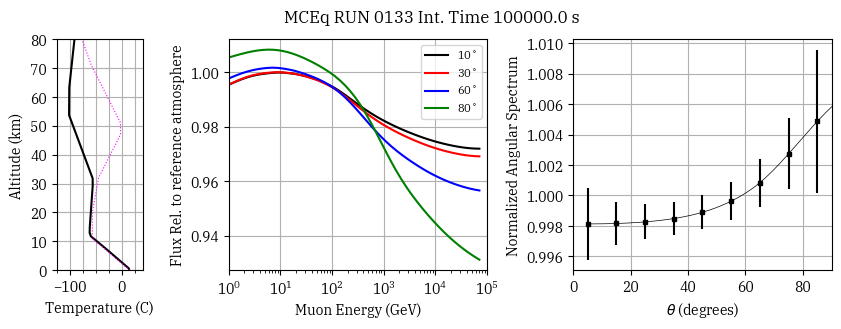

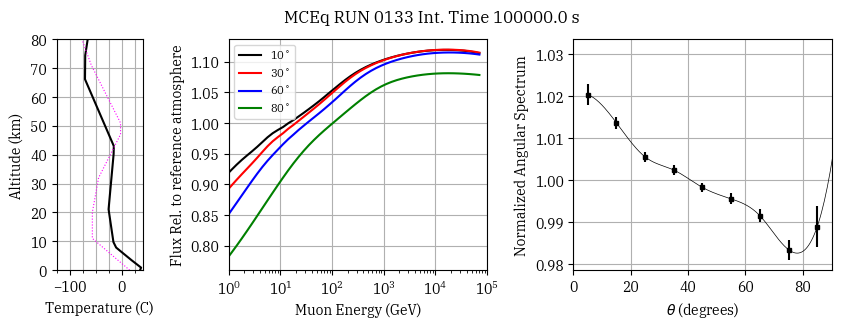

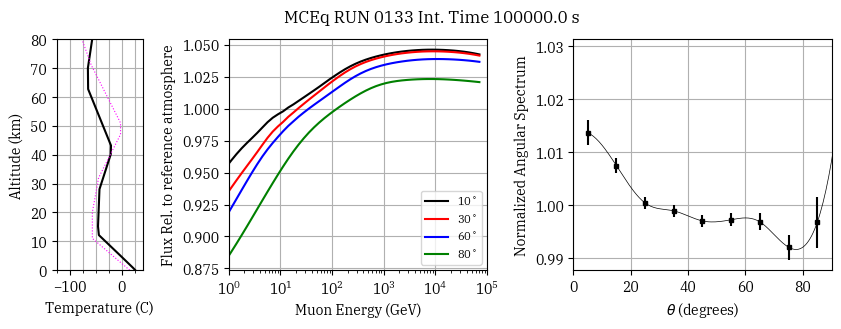

In [15]:
compare_atmospheres(data, ref_flux, 133, 19, grid_idx=4, integration_time=1E5, ref_atm=isa.profile)
compare_atmospheres(data, ref_flux, 133, 20, grid_idx=4, integration_time=1E5, ref_atm=isa.profile)
compare_atmospheres(data, ref_flux, 133, 21, grid_idx=4, integration_time=1E5, ref_atm=isa.profile)

## Temperature Reconstruction - Part II
Still pretty early in development of ground flux to temperature at altitude solver but let's try out some ideas using support vector machine regression models (SVR models). The fluxes must still be turned into detector observables. I create a hypothetical surface detector that bins in energy and angle with perfect resolution and integrate the fluxes over (E, theta) to come up with bin event counts (per unit time). Compare these to a reference flux - our ISA, well sorta, defined above.

I've already tried fitting the SVR using perfect statistics - i.e. infinite integration time. This gives great results ($\delta T \sim 2 K$) for predicting observations taken over infinitely long intervals, alas it totally falls apart for finite exposures. So let's train with long but finite exposure data (week-ish time scale).

In [16]:
from scipy.interpolate import RectBivariateSpline
from scipy.integrate import dblquad

from sklearn import svm

In [18]:
class Flux2D:
    """
    A class for manipulation of two dimensional (energy, angle) flux tables.

    Parameters
    ----------
    theta : 1D numpy.ndarray of shape (NT,)
        Array of theta bin locations in table, __in radians__.
    energy : 1D numpy.ndarray of shape (NE,)
        Array of energy bins in table.
    tab : 2D numpy.ndarray shape (NT, NE)
        Discrete tabular flux tab[theta, energy]
    """

    def __init__(self, theta, energy, tab):
        self.theta = theta
        self.e = energy
        self.f_spl = RectBivariateSpline(theta, np.log10(energy), tab * energy)

    def integrate(self, E0, E1, theta0, theta1) -> float:
        logE0 = np.log10(E0)
        logE1 = np.log10(E1)
        cost0 = np.cos(theta0)
        cost1 = np.cos(theta1)
        Q, dQ = dblquad(
            lambda u, logE: self.f_spl(np.arccos(u), logE),
            logE0, logE1, cost1, cost0) 
        return Q * 1E4 * np.log(10) * 2 * np.pi

The array `X` below will hold counts corresponding to one second of exposure in a detector of $1\;\mathrm{m^2}$. See below, we can adjust the exposure parameter later without incurring the long processing time (5 minutes) that this cell takes to complete because of all the splining and integration.

In [19]:
grid_idx = 4
ibounds = ((1E0, 2E0,  0, 30), (2E0, 2E2,  0, 30), (2E2, 5E4,  0, 30), # theta = 0:30
           (1E0, 2E0, 30, 45), (2E0, 5E0, 30, 45), (5E0, 2E2, 30, 45), # theta = 30:45
           (2E2, 5E4, 30, 45), # -------------------------------------
           (1E0, 2E0, 45, 60), (2E0, 5E0, 45, 60), (5E0, 1E1, 45, 60), # theta = 45:60 
           (1E1, 2E2, 45, 60), (2E2, 5E4, 45, 60), # -----------------
           (1E0, 2E0, 60, 75), (2E0, 5E0, 60, 75), (5E0, 1E1, 60, 75), # theta = 60:75 
           (1E1, 2E2, 60, 75), (2E2, 5E5, 60, 75), # -----------------
           (1E0, 2E0, 75, 90), (2E0, 5E0, 75, 90), (5E0, 1E1, 75, 90), # theta = 75:90 
           (1E1, 2E1, 75, 90), (2E1, 2E2, 70, 90), (2E2, 5E4, 75, 90))

r2 = Flux2D(np.deg2rad(data['theta']), data['e_grid'], ref_flux[grid_idx])
REFth = np.array(
    [r2.integrate(e0, e1, np.deg2rad(a0), np.deg2rad(a1)) 
     for e0, e1, a0, a1 in ibounds], 'd')
    
X = []
y = []

for flux in data['flux']:
    f2 = Flux2D(np.deg2rad(data['theta']), data['e_grid'], flux[grid_idx])
    X.append(
        [f2.integrate(e0, e1, np.deg2rad(a0), np.deg2rad(a1))for e0, e1, a0, a1 in ibounds]
    )

X = np.array(X)

In [21]:
y = []
altitude = 10000.0
for atm in data['atm']:
    z, T = atm.T
    a = AtmospherefromTemperatureProfile(alt = z, T = T)
    y.append(a._Tspline(altitude))
y = np.array(y)

Now simulate finite exposure by multiplying by exposure and drawing a Poisson random variable. I 10x oversample the training data by drawing new Poisson r.v.'s to increase fit patterns.

In [52]:
Xtrain = [] 
ytrain = []
exposure = 24 * 3600
for i in range(10):
    Xtrain.append(100*(np.random.poisson(lam=X[0:2500] * exposure) / (REFth * exposure) - 1))
    ytrain.append(y[0:2500])

Xtrain = np.vstack(Xtrain)
ytrain = np.concatenate(ytrain)

Train ...

In [53]:
model = svm.SVR(kernel='linear', tol=1E-4, C=0.5)
model.fit(Xtrain, ytrain)

SVR(C=0.5, kernel='linear', tol=0.0001)

Here's the performance of the model on trained data.

Text(0, 0.5, 'SVR Estimator Value (K)')

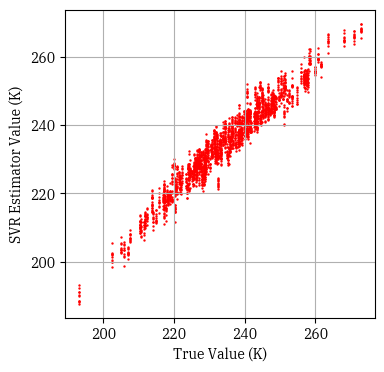

In [25]:
fig = plt.figure(figsize=(4,4))
plt.scatter(ytrain[::10], model.predict(Xtrain[::10]), s=0.5, color='r')
plt.xlabel('True Value (K)')
plt.ylabel('SVR Estimator Value (K)')

Evaluate on validation data. Since this is a linear kernel it seems to be pretty robust at predicting on data it's never seen before. Let's try 8 hour exposure.

In [27]:
exposure = 3600*8
Xval = 100*(np.random.poisson(lam=X[2500:] * exposure) / (REFth * exposure) - 1)
yval = y[2500:]

Text(0, 0.5, 'SVR Estimator Value (K)')

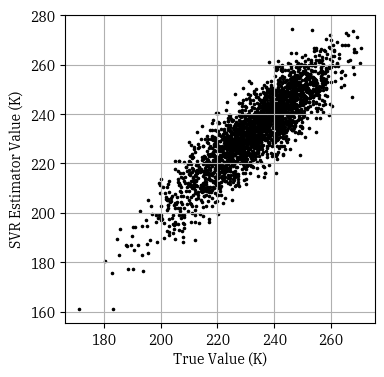

In [28]:
fig = plt.figure(figsize=(4,4))
plt.scatter(yval, model.predict(Xval), s=2.5, color='k')
plt.xlabel('True Value (K)')
plt.ylabel('SVR Estimator Value (K)')

RMS Error on temperature is 7.5 °C


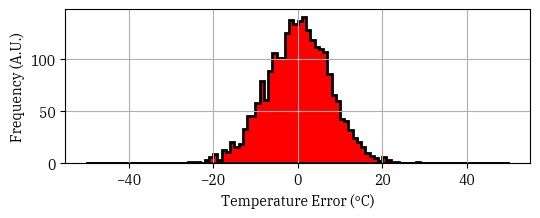

In [37]:
fig = plt.figure(figsize=(6,2))
t_err = [y - x for x, y in list(zip(yval, model.predict(Xval)))]
plt.hist(t_err, bins=np.linspace(-50, 50, 101), histtype='stepfilled', color='r', ec='k', lw=2)
plt.xlabel("Temperature Error (°C)")
plt.ylabel("Frequency (A.U.)")
print(f"RMS Error on temperature is {np.std(t_err):.1f} °C")

Text(0, 0.5, 'SVR Estimator Value (K)')

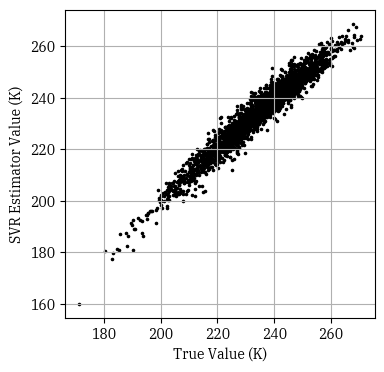

In [50]:
exposure = 3600*12*10
Xval = 100*(np.random.poisson(lam=X[2500:] * exposure) / (REFth * exposure) - 1)
yval = y[2500:]
fig = plt.figure(figsize=(4,4))
plt.scatter(yval, model.predict(Xval), s=2.5, color='k')
plt.xlabel('True Value (K)')
plt.ylabel('SVR Estimator Value (K)')

RMS Error on temperature is 3.4 °C


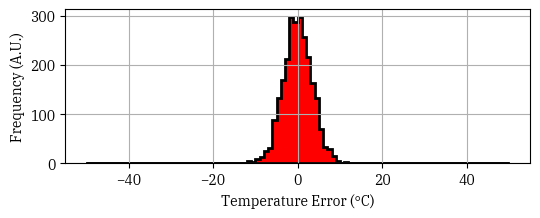

In [51]:
fig = plt.figure(figsize=(6,2))
t_err = [y - x for x, y in list(zip(yval, model.predict(Xval)))]
plt.hist(t_err, bins=np.linspace(-50, 50, 101), histtype='stepfilled', color='r', ec='k', lw=2)
plt.xlabel("Temperature Error (°C)")
plt.ylabel("Frequency (A.U.)")
print(f"RMS Error on temperature is {np.std(t_err):.1f} °C")